<center> Imports <center>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np


 <center> Import check_in data from Yelp dataset <center>

In [2]:
file = '/Users/Lisa/Downloads/yelp_dataset/yelp_academic_dataset_checkin.json'

In [3]:
checkins = pd.read_json(file, lines=True)

In [4]:
checkins

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."
...,...,...
175182,zzvlwkcNR1CCqOPXwuvz2A,"2017-05-06 20:05:15, 2017-05-12 22:37:03, 2017..."
175183,zzwaS0xn1MVEPEf0hNLjew,"2010-02-16 02:09:56, 2010-07-05 05:40:48, 2010..."
175184,zzwhN7x37nyjP0ZM8oiHmw,"2016-03-06 13:27:02, 2016-03-09 00:41:53, 2016..."
175185,zzwicjPC9g246MK2M1ZFBA,"2012-09-22 00:26:15, 2012-09-23 20:12:00, 2012..."


 <center> Since the date column is a long string I'll need to change it to a list in order to leverage date/time for future graphing <center>

In [5]:
checkins['date'] = checkins['date'].apply(lambda x: x.split(","))

 <center> Leverage dataframe.explode('column_name') to break the list of check-in's down <center>

In [45]:
checkins_broken_down = checkins.explode('date')

 <center> From my EDA is seems like each business has a unique business_id which gives a breakdown of the dates people checked in to these businesses. I can use that to compare against the weather for those dates. <br/> Now Identify the locations with enough data points to scrap weather data for <center>

 <center> Import Business data from Yelp dataset <center>

In [7]:
file2 = '/Users/Lisa/Downloads/yelp_dataset/yelp_academic_dataset_business.json'

In [44]:
businesses = pd.read_json(file2, lines=True)

 <center> Clean up businesses dataframe and elimnate unnecessary columns since its not data I need to focus on <center>

In [9]:
businesses = businesses.drop(['hours', 'categories', 'attributes', 'longitude', 'latitude', 'stars', 'is_open', 'address', 'postal_code', 'review_count'], axis=1)

 <center> Idnetify a State with enough data points to work with (since there's a lot of entries) <center>

In [10]:
businesses.groupby('state').count()

,business_id,name,city
state,,,
AB,8682,8682,8682
AK,1,1,1
AL,3,3,3
AR,1,1,1
AZ,60803,60803,60803
BC,2,2,2
CA,23,23,23
CO,2,2,2
CT,2,2,2


<center>It seems like Arizona has the most amount of Yelp Activity <br/> Determine which city to focus on in AZ. <br/> Groupby and sort the counted data<center>

In [11]:
AZ = businesses.loc[businesses['state'] == 'AZ'].groupby('city').count()

<center>Take the grouped data and sort it<center>

In [12]:
AZ.sort_values('state', ascending=False)

,business_id,name,state
city,,,
Phoenix,20170,20170,20170
Scottsdale,9341,9341,9341
Mesa,6577,6577,6577
Tempe,4797,4797,4797
Chandler,4579,4579,4579
...,...,...,...
Mesa Az,1,1,1
Mesa Arizona,1,1,1
Mes,1,1,1


 <center> Through EDA, it seems like Phoenix has the greatest activity to measure against weather. Will focus on Yelp check-in's there<center>

 <center> Pull Pheonix, AZ from the businesses dataframe <center>

In [14]:
phx_az_biz = businesses.loc[(businesses['city']=='Phoenix') & (businesses['state']=='AZ')]

 <center> Merge Phoenix, AZ dataframe to checkins_broken_down <center>

In [47]:
# Merge on checkins to calculate mean
mean_checks = phx_az_biz.merge(checkins, how='left', on='business_id')
mean_checks

,business_id,name,city,state,date
0,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,"[2010-08-17 01:02:24, 2011-07-08 23:11:37, 2..."
1,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,AZ,"[2010-07-06 21:38:52, 2010-08-29 17:19:51, 2..."
2,kHCTmEekJJwYsJEy7xYM5w,Banner - University Family Medicine Center,Phoenix,AZ,"[2016-07-26 21:34:33, 2018-01-30 18:17:33, 2..."
3,Mmd5WDFq9hHcQ3uClngGjQ,Irene's Tap Room,Phoenix,AZ,"[2018-07-26 00:43:23, 2018-07-26 02:50:46, 2..."
4,YFsb1ydMxFLrxtJ3CffVhw,LA Fitness,Phoenix,AZ,"[2010-03-02 23:16:15, 2010-06-14 22:33:36, 2..."
...,...,...,...,...,...
20165,IldalZigWbk1TlguWHC2gQ,Aeon Internet Marketing,Phoenix,AZ,NaN
20166,FcRktj50Mz6sGp1zKvHBMA,Dollar General,Phoenix,AZ,"[2013-09-06 21:21:19, 2014-06-04 22:43:59, 2..."
20167,PR1u3jlwNZC0Z2viweTpLA,Integrative Vet Med Center,Phoenix,AZ,"[2016-08-13 17:45:32, 2017-03-06 16:52:59, 2..."
20168,-2KAjVCxfQ2YsmuXYLNEpw,DENNIS Uniform Phoenix,Phoenix,AZ,"[2017-01-08 04:47:56, 2018-01-11 20:48:44, 2..."


In [15]:
phx_checkins = phx_az_biz.merge(checkins_broken_down, how='left', on='business_id')

 <center> get date/time to a workable data type (not a string!) <center>

<center> Example: data["Date"]= pd.to_datetime(data["Date"]) <center>

In [16]:
phx_checkins['date'] = pd.to_datetime(phx_checkins['date'])

In [17]:
phx_checkins['date2.0'] = phx_checkins['date'].dt.date

In [18]:
phx_checkins = phx_checkins.drop('date', axis=1)

 <center> Groupby and count dates <center>

 <center> Break up phx_checkins by years <center>

In [19]:
phx_checkins

,business_id,name,city,state,date2.0
0,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2010-08-17
1,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-07-08
2,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-08
3,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-09
4,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-21
...,...,...,...,...,...
2433944,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-05-03
2433945,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-07-29
2433946,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-04
2433947,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-07


In [20]:
# check to see how to access date/time
print(phx_checkins.iloc[0,4].month)
print(phx_checkins.iloc[0,4].day)
print(phx_checkins.iloc[0,4].year)

8
17
2010


In [21]:
# new columns for month, date, year
phx_checkins['Month'] = phx_checkins['date2.0'].apply(lambda x: x.month)

In [22]:
phx_checkins['Day'] = phx_checkins['date2.0'].apply(lambda x: x.day)

In [23]:
phx_checkins['Year'] = phx_checkins['date2.0'].apply(lambda x: x.year)

In [24]:
phx_checkins

,business_id,name,city,state,date2.0,Month,Day,Year
0,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2010-08-17,8.0,17.0,2010.0
1,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-07-08,7.0,8.0,2011.0
2,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-08,8.0,8.0,2011.0
3,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-09,8.0,9.0,2011.0
4,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-21,8.0,21.0,2011.0
...,...,...,...,...,...,...,...,...
2433944,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-05-03,5.0,3.0,2019.0
2433945,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-07-29,7.0,29.0,2019.0
2433946,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-04,8.0,4.0,2019.0
2433947,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-07,8.0,7.0,2019.0


 <center> Get a breakdown by year and the total amount of checkins. Next will be to separate them into years <center>

In [25]:
phx_checkins_years = phx_checkins.groupby('Year').count()
phx_checkins_years

,business_id,name,city,state,date2.0,Month,Day
Year,,,,,,,
2010.0,47024,47024,47024,47024,47024,47024,47024
2011.0,213274,213274,213274,213274,213274,213274,213274
2012.0,282346,282346,282346,282346,282346,282346,282346
2013.0,333793,333793,333793,333793,333793,333793,333793
2014.0,345027,345027,345027,345027,345027,345027,345027
2015.0,315325,315325,315325,315325,315325,315325,315325
2016.0,275605,275605,275605,275605,275605,275605,275605
2017.0,239295,239295,239295,239295,239295,239295,239295
2018.0,206156,206156,206156,206156,206156,206156,206156


In [26]:
checkins_2019 = phx_checkins.loc[phx_checkins['Year'] == 2019]
checkins_2019

,business_id,name,city,state,date2.0,Month,Day,Year
43,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,AZ,2019-06-15,6.0,15.0,2019.0
44,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,AZ,2019-10-26,10.0,26.0,2019.0
48,kHCTmEekJJwYsJEy7xYM5w,Banner - University Family Medicine Center,Phoenix,AZ,2019-10-24,10.0,24.0,2019.0
123,Mmd5WDFq9hHcQ3uClngGjQ,Irene's Tap Room,Phoenix,AZ,2019-01-03,1.0,3.0,2019.0
124,Mmd5WDFq9hHcQ3uClngGjQ,Irene's Tap Room,Phoenix,AZ,2019-01-06,1.0,6.0,2019.0
...,...,...,...,...,...,...,...,...
2433944,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-05-03,5.0,3.0,2019.0
2433945,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-07-29,7.0,29.0,2019.0
2433946,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-04,8.0,4.0,2019.0
2433947,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-07,8.0,7.0,2019.0


 <center> Now that I have 2019 checkin data, break it down by months for plotting<center>

In [27]:
# Get a count of businesses per day
# phx_az_biz = businesses.loc[(businesses['city']=='Phoenix') & (businesses['state']=='AZ')]

In [56]:
test = checkins_2019.loc[ (checkins_2019['Day'] == 1) & (checkins_2019['Month'] == 1)]
test = test.groupby('business_id').count()
test = test.reset_index()
test = test['business_id'].unique()
test

array(['-BxWyEIQ6wypT-37MzZizQ', '-Ma5JqzuI_3xIAtpNJfQ2g',
       '-TVXOYL6kvKP1uW6ND9PIg', '-ZBfr1BHvArFp1d6XH8jOQ',
       '-bMZCfTK7fxFaURynKpBMA', '042IHd5KjHiMuBtGtugO_g',
       '0CElIQnJdQYF2bmsAiWczg', '0TLaM_dTjAYzfb_6ZUEkEA',
       '0V18KwdtfsdrIu9xyO4GLg', '0cfW3VvzM14pQiA3yvqzNg',
       '0npO65UyjyjM0ZjKawvTbw', '19LQmaLOi22V5RrI3eB5lA',
       '1CqDdPrrb0xvQpgu7fhI5w', '1ZUszwN0CVPMcLuGe0UAMg',
       '1e6Xtmd4BetTnsoRCK3J5g', '1e7GXqhVDs0UXUofjTkVgQ',
       '2IHmggMLM-hDq4dFmwgzDw', '2K8AMc9xKWMj5TldD4eW2Q',
       '2adhYiY1IQ5flntw30Sdew', '3C5Z9homtzkWHouH2BHXYQ',
       '3QQEc5QUP-h6LCkUZQEYQw', '3dsvREiTlmGaaBjsBS4dwQ',
       '3oTVApC-eUzpGjrOVxIr5g', '3rWRNL9sFX4YiWPqaUvUzw',
       '3sZ3Fd_RKNRN_6Kh-zAg5g', '44YFU284Z3KDEy25QyVoUw',
       '4E0sK671C98JW8nakFbUnQ', '4rnfwRvwAHSQfsihafmaXA',
       '53BSdnhzcCBfBH_6TgX63Q', '591UZJIUNgPwxXRvQMIUkw',
       '59UK1BDCstvfcdSGnOKioQ', '5BA9l5NiPYI_MfoiWnWLGw',
       '5KheTjYPu1HcQzQFtm4_vw', '5RqU2YARBU69d9zK6h-fXg

In [53]:
len(test)

330

In [90]:
def rest_per_day_jan(df):
    lst = []
    a = np.arange(1,32)
    total = df.loc[ (df['Day'] == 1) & (df['Month'] == 1)]

In [91]:
rest_per_day_jan(checkins_2019)

dict_keys([])

In [29]:
def create_df(x):
    x = x['Day'].sort_values()
    x = x.to_frame()
    return x

In [30]:
jan_checkins_2019 = checkins_2019[checkins_2019['Month'] == 1]
jan_hist = create_df(jan_checkins_2019)
jan_hist

,Day
2182910,1.0
2356412,1.0
1308750,1.0
1308749,1.0
1308748,1.0
...,...
1944903,31.0
153234,31.0
1944902,31.0
1946597,31.0


In [31]:
feb_checkins_2019 = checkins_2019[checkins_2019['Month'] == 2]
feb_hist = create_df(feb_checkins_2019)

In [32]:
march_checkins_2019 = checkins_2019[checkins_2019['Month'] == 3]
mar_hist = create_df(march_checkins_2019)

In [33]:
april_checkins_2019 = checkins_2019[checkins_2019['Month'] == 4]
apr_hist = create_df(april_checkins_2019)

In [34]:
may_checkins_2019 = checkins_2019[checkins_2019['Month'] == 5]
may_hist = create_df(may_checkins_2019)

In [35]:
june_checkins_2019 = checkins_2019[checkins_2019['Month'] == 6]
jun_hist = create_df(june_checkins_2019)

In [36]:
july_checkins_2019 = checkins_2019[checkins_2019['Month'] == 7]
jul_hist = create_df(july_checkins_2019)

In [37]:
august_checkins_2019 = checkins_2019[checkins_2019['Month'] == 8]
aug_hist = create_df(august_checkins_2019)

In [38]:
sept_checkins_2019 = checkins_2019[checkins_2019['Month'] == 9]
sept_hist = create_df(sept_checkins_2019)

In [39]:
oct_checkins_2019 = checkins_2019[checkins_2019['Month'] == 10]
oct_hist = create_df(oct_checkins_2019)

In [40]:
nov_checkins_2019 = checkins_2019[checkins_2019['Month'] == 11]
nov_hist = create_df(nov_checkins_2019)

In [41]:
dec_checkins_2019 = checkins_2019[checkins_2019['Month'] == 12]
dec_hist = create_df(dec_checkins_2019)

### <center> Test out graphing by month <center>

In [42]:
x_ticks = jan_checkins_2019['Day'].unique()
x_ticks = np.sort(x_ticks)
x_ticks

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31.])

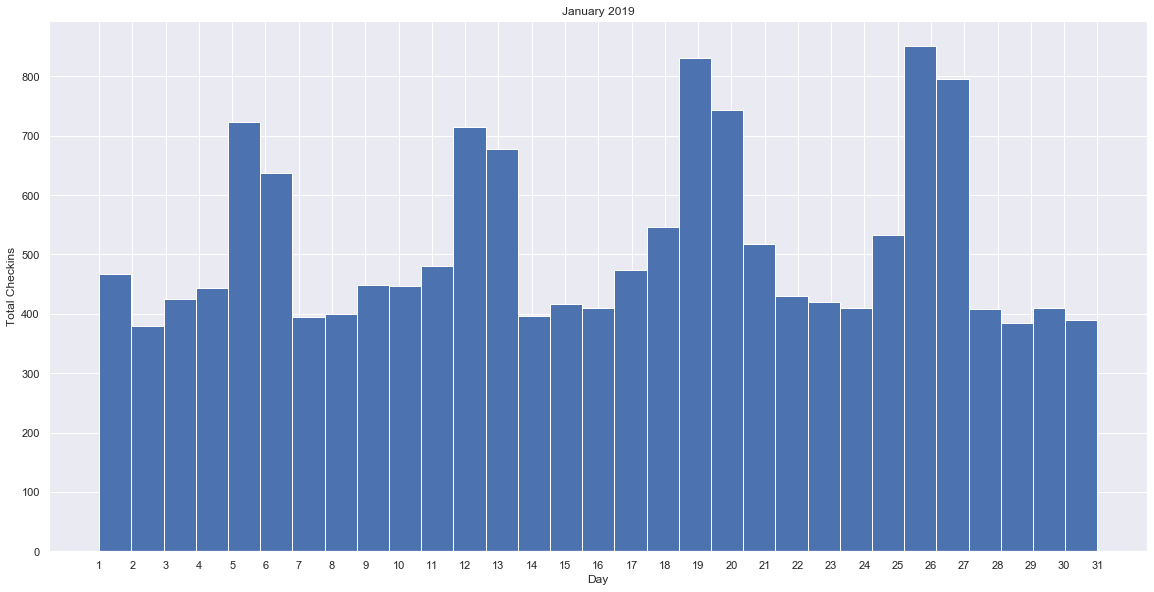

In [43]:
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(x = jan_checkins_2019['Day'], bins=len(jan_checkins_2019['Day'].unique()), align='mid')
plt.xticks(x_ticks)
plt.tight_layout()
ax.set_xlabel('Day')
ax.set_ylabel('Total Checkins')
ax.title.set_text("January 2019")